In [26]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
data2019 = requests.get('https://api.census.gov/data/2018/abscs?get=NAME,GEO_ID,NAICS2017_LABEL,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP&for=state:*&NAICS2017=00&key=a4bcb4614372e8f229066cbce694ccdb6b558ef4').json()

In [28]:
data2020 = requests.get('https://api.census.gov/data/2019/abscs?get=NAME,GEO_ID,NAICS2017_LABEL,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP&for=state:*&NAICS2017=00&key=a4bcb4614372e8f229066cbce694ccdb6b558ef4').json()

In [29]:
companysummarystate2019 = pd.DataFrame (data2019[1:], columns= data2019[0])

In [30]:
companysummarystate2020 = pd.DataFrame(data2020[1:], columns = data2020[0])

In [31]:
companysummarystate2019.drop(columns = ['GEO_ID','NAICS2017_LABEL','NAICS2017','state'], inplace=True)

In [32]:
companysummarystate2020.drop(columns = ['GEO_ID','NAICS2017_LABEL','NAICS2017','state'], inplace=True)

In [33]:
companysummarystate2019.head()

,NAME,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP
0,Mississippi,002,029,00,003,0
1,Mississippi,003,029,00,003,466
2,Mississippi,004,029,00,003,572
3,Mississippi,001,001,30,003,926
4,Mississippi,096,096,96,096,37489


In [34]:
companysummarystate2020.head()

,NAME,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP
0,Mississippi,001,028,00,001,93
1,Mississippi,003,028,00,001,0
2,Mississippi,002,029,50,001,0
3,Mississippi,003,029,50,001,51
4,Mississippi,001,001,60,001,2489


In [35]:
companysummarystate2019.FIRMPDEMP.isna().value_counts()

False    9668
Name: FIRMPDEMP, dtype: int64

In [36]:
companysummarystate2020.FIRMPDEMP.isna().value_counts()

False    9641
Name: FIRMPDEMP, dtype: int64

In [37]:
statemerge = companysummarystate2019.merge(companysummarystate2020, on=['NAME', 'SEX', 'ETH_GROUP', 'RACE_GROUP', 'VET_GROUP'], how='inner', suffixes = ('_2019', '_2020') )

The totals for each column are 001, except Race_Group which is 00.
Make sure that you filter for totals on all the other columns except for the ones you are looking at fo

In [38]:
statemerge

,NAME,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP_2019,FIRMPDEMP_2020
0,Mississippi,003,029,00,003,466,334
1,Mississippi,004,029,00,003,572,0
2,Mississippi,001,001,30,003,926,801
3,Mississippi,096,096,96,096,37489,37057
4,Mississippi,002,001,00,001,6659,7751
...,...,...,...,...,...,...,...
9133,Minnesota,002,029,00,003,0,0
9134,Minnesota,003,029,00,003,941,1128
9135,Minnesota,004,029,00,003,0,1877
9136,Minnesota,001,001,30,003,0,3025


In [47]:
pd.options.mode.chained_assignment = None

In [49]:
#changing data to numeric values for easier plotting
statemerge['FIRMPDEMP_2020'] = pd.to_numeric(statemerge['FIRMPDEMP_2020'])
statemerge['FIRMPDEMP_2019'] = pd.to_numeric(statemerge['FIRMPDEMP_2019'])

In [86]:
#filtering the data so i get data for minority women owned firms
onestatemerge = statemerge.loc[(statemerge['SEX'] == '002') & (statemerge['ETH_GROUP'] == '001') & (statemerge['RACE_GROUP'] == '90') & (statemerge['VET_GROUP'] == '001')]
print(onestatemerge)

                      NAME  SEX ETH_GROUP RACE_GROUP VET_GROUP  \
123            Mississippi  002       001         90       001   
279               Missouri  002       001         90       001   
422                Montana  002       001         90       001   
603               Nebraska  002       001         90       001   
839                 Nevada  002       001         90       001   
919          New Hampshire  002       001         90       001   
1174            New Jersey  002       001         90       001   
1245            New Mexico  002       001         90       001   
1534              New York  002       001         90       001   
1666        North Carolina  002       001         90       001   
1824          North Dakota  002       001         90       001   
2117                  Ohio  002       001         90       001   
2183              Oklahoma  002       001         90       001   
2362                Oregon  002       001         90       001   
2522      

In [107]:
#checking datatypes
result = onestatemerge.dtypes
print(result)

NAME              object
SEX               object
ETH_GROUP         object
RACE_GROUP        object
VET_GROUP         object
FIRMPDEMP_2019     int64
FIRMPDEMP_2020     int64
dtype: object


In [109]:
#changing state name data type so it can be plotted
onestatemerge['NAME'] = onestatemerge['NAME'].astype('|S')

In [110]:
#making sure state name data type changed
result = onestatemerge.dtypes
print(result)

NAME                |S20
SEX               object
ETH_GROUP         object
RACE_GROUP        object
VET_GROUP         object
FIRMPDEMP_2019     int64
FIRMPDEMP_2020     int64
dtype: object


Text(0, 0.5, 'Number of firms')

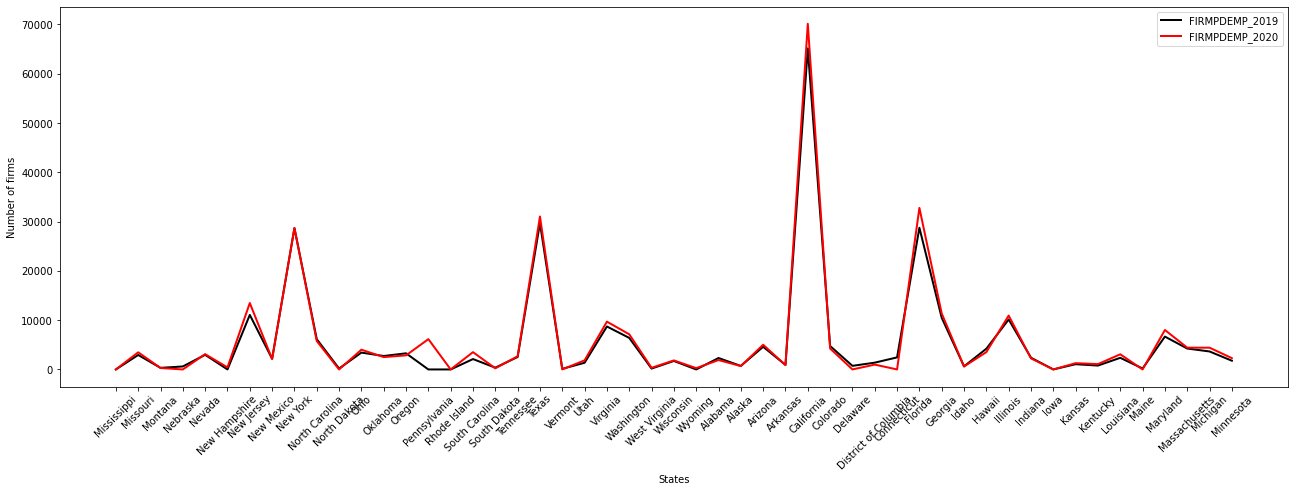

In [112]:
#plotting chart to find out how the number of businesses has changed from 2019 to 2020
plt.figure(figsize=(22, 8))
plt.plot( 'NAME', 'FIRMPDEMP_2019', data= onestatemerge, color='black', linewidth=2)
plt.plot( 'NAME', 'FIRMPDEMP_2020', data= onestatemerge, color='red', linewidth=2)
plt.legend()
plt.xlabel('States')
plt.xticks(rotation = 45)
spacing = 0.220
plt.subplots_adjust(bottom=spacing)
plt.ylabel('Number of firms')


<Figure size 288x72 with 0 Axes>